# EMD Lung Sound

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import librosa.display
import pandas as pd
import wave

/home/andrine/anaconda3/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/andrine/anaconda3/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Downsampling the sampling rate to be 8000

In [3]:
sr = 3000
data_path = 'audio_samples/'
file_names = [file_name for file_name in os.listdir(data_path) if '.wav' in file_name] 
audio_file = data_path + file_names[1]
audio, sr = librosa.load(audio_file, sr = sr)

<IPython.core.display.Javascript object>


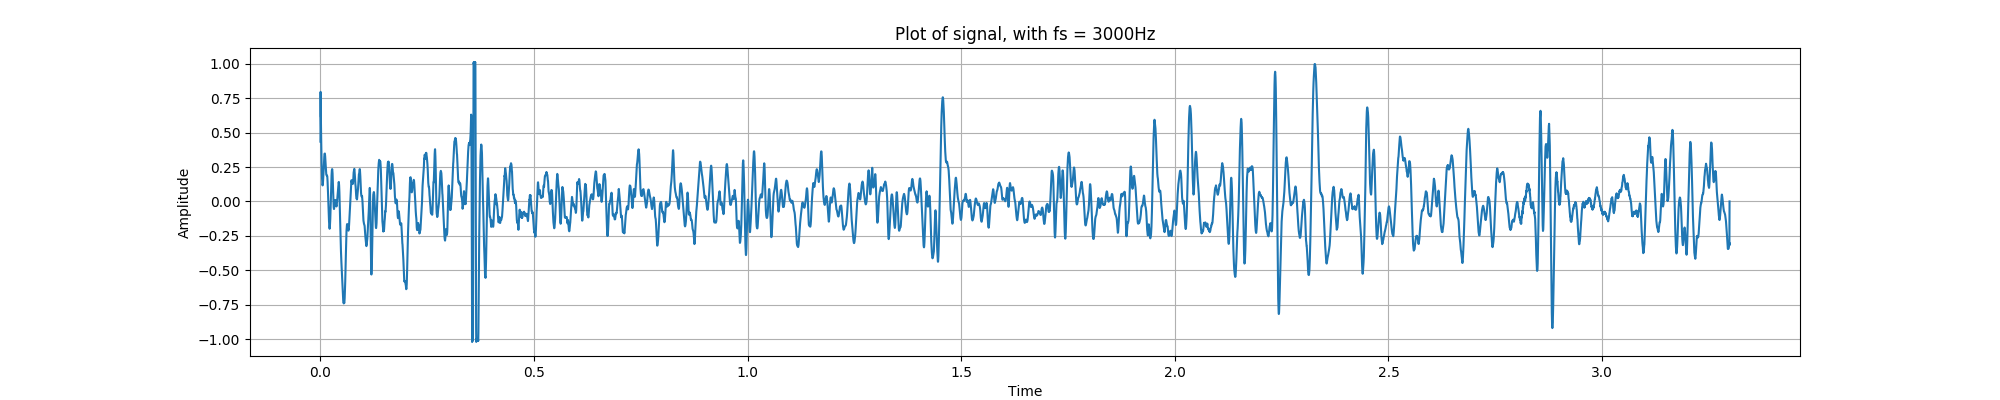

In [4]:
duration = float(len(audio)) / sr
T = 1.0/sr
N = int(duration / T)

y = audio
x = np.linspace(0.0, N*T, N)

plt.figure(figsize=(20, 4))
plt.plot(x, y)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title(f'Plot of signal, with fs = {sr}Hz')
plt.grid()
plt.draw()

In [5]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

<IPython.core.display.Javascript object>


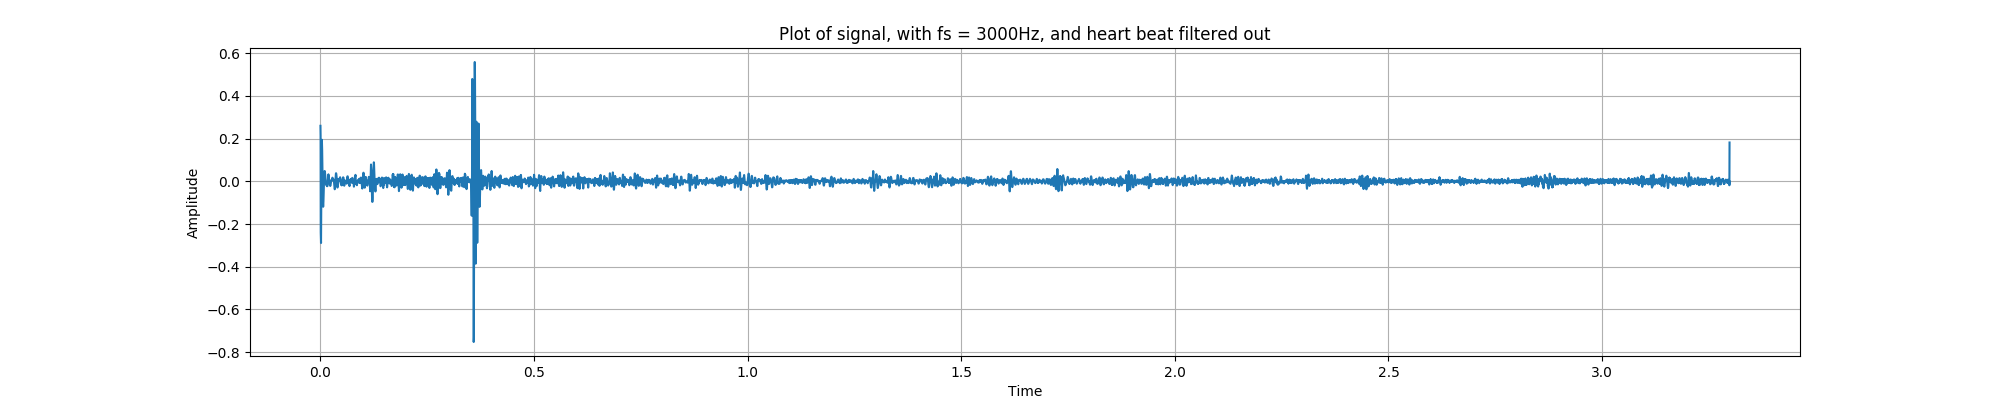

In [6]:
lowcut = 150
highcut = sr/2.0 - 1  #Should be 2000 here

y_filtered = butter_bandpass_filter(y , lowcut, highcut, sr)

plt.figure(figsize=(20, 4))
plt.plot(x, y_filtered)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title(f'Plot of signal, with fs = {sr}Hz, and heart beat filtered out')
plt.grid()
plt.draw()

<IPython.core.display.Javascript object>


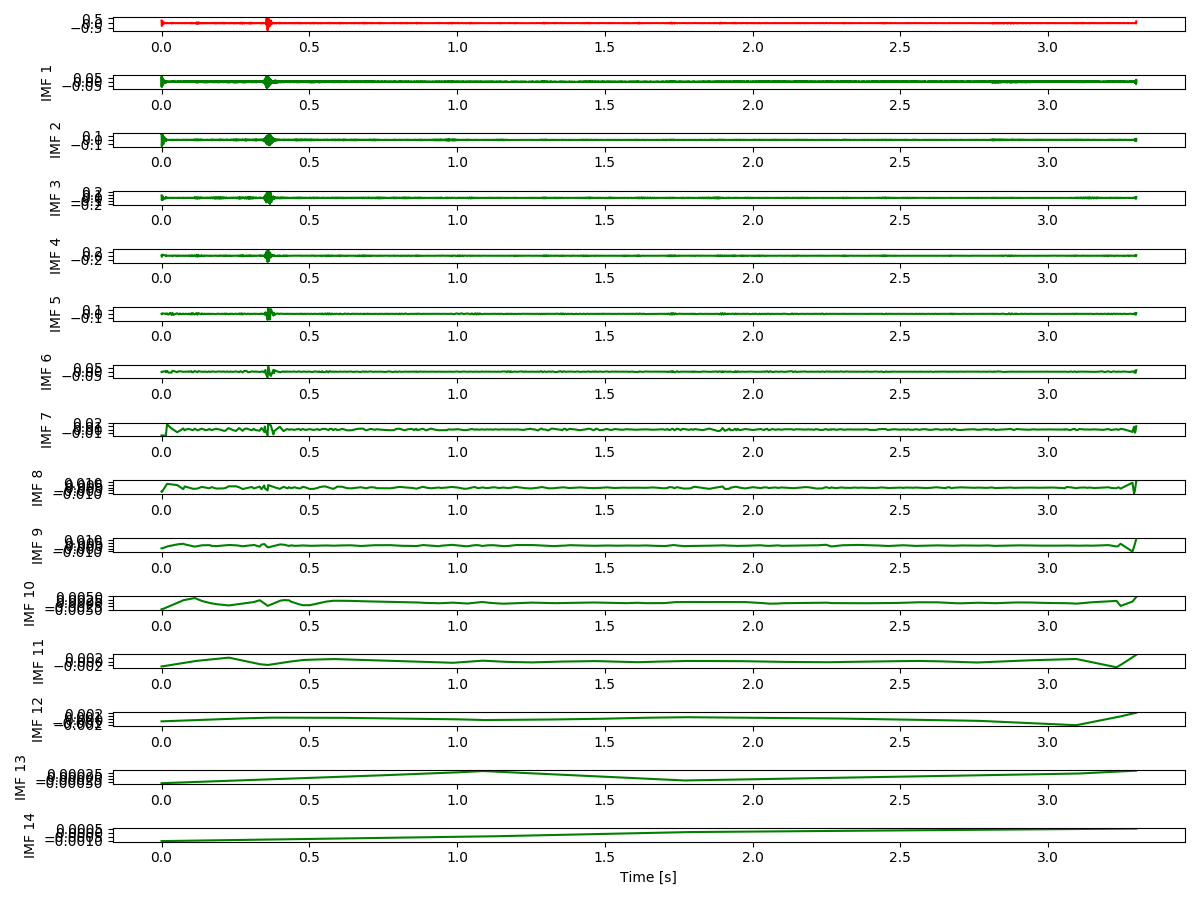

In [7]:
from PyEMD import EEMD
import numpy as np
import pylab as plt
from PyEMD import EMD

# Say we want detect extrema using parabolic method
emd = EMD()
emd.spline_kind="slinear"

# Execute EEMD on S
IMFs = emd.emd(y_filtered, x)
nIMFs = IMFs.shape[0]

# Plot results
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(x, y_filtered, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(x, IMFs[n], 'g')
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

Use EEMD instead ?? 

<IPython.core.display.Javascript object>


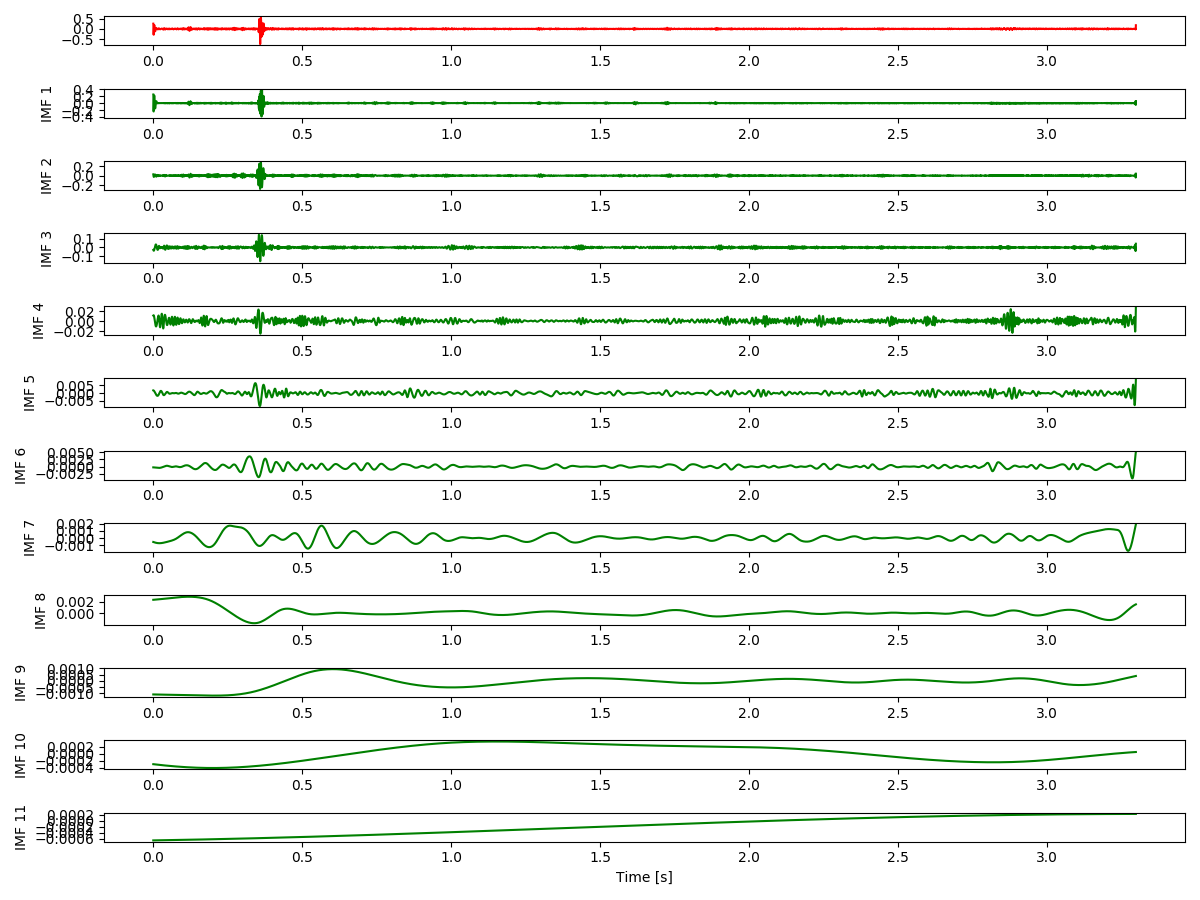

In [8]:
from PyEMD import EEMD
import numpy as np
import pylab as plt
from PyEMD import EMD

# Say we want detect extrema using parabolic method
eemd = EEMD()
eemd.spline_kind="slinear"

# Execute EEMD on S
eIMFs = eemd.emd(y_filtered, x)
neIMFs = eIMFs.shape[0]

# Plot results
plt.figure(figsize=(12,9))
plt.subplot(neIMFs+1, 1, 1)
plt.plot(x, y_filtered, 'r')

for n in range(neIMFs):
    plt.subplot(neIMFs+1, 1, n+2)
    plt.plot(x, eIMFs[n], 'g')
    plt.ylabel("IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


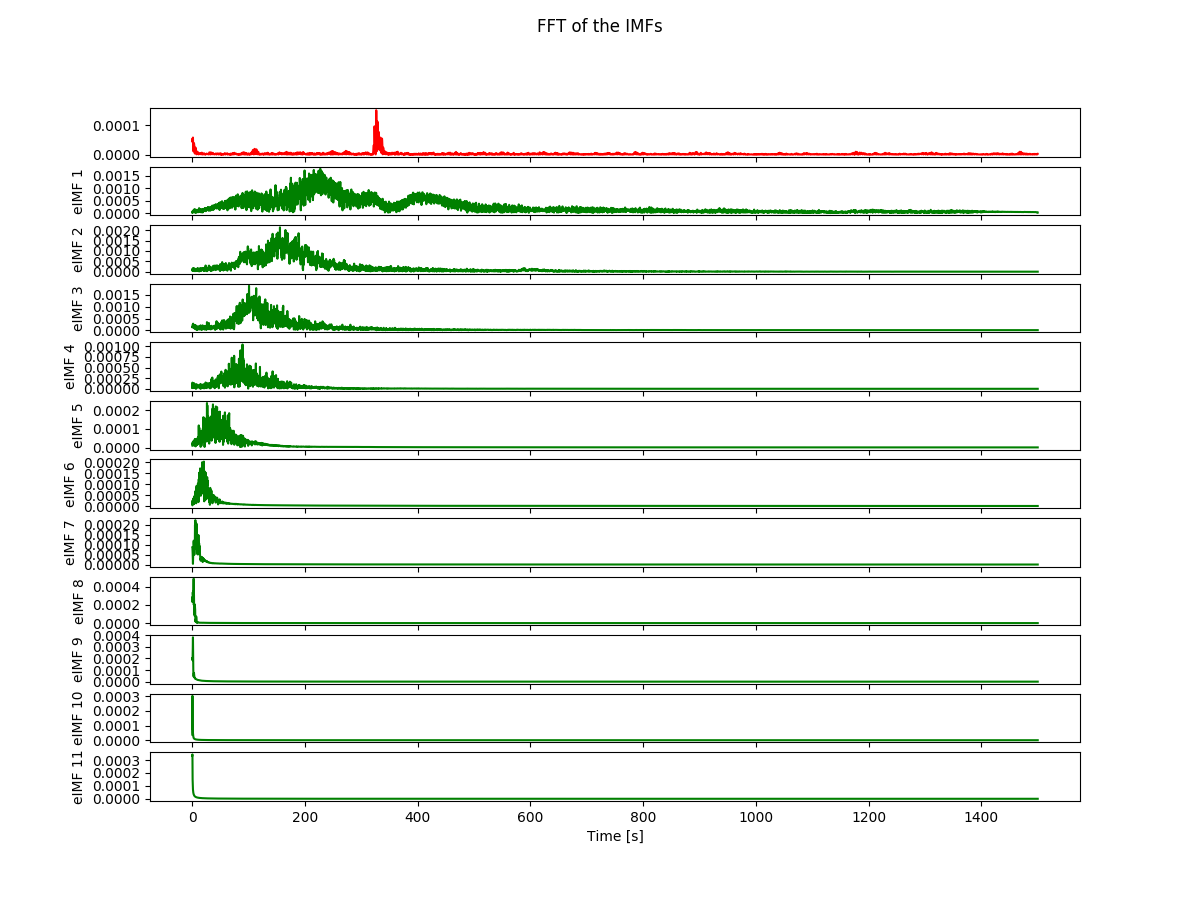

Text(0.5, 0.98, 'FFT of the IMFs')

In [9]:
from scipy.fftpack import fft
yf = fft(y_filtered)

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
# Plot results
plt.figure(figsize=(12,9))


plt.subplot(neIMFs+1, 1, 1)
plt.plot(xf, 2.0/N * np.abs(y_filtered[0:N//2]), 'r')

for n in range(neIMFs):
    y_filtered = fft(eIMFs[n])

    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    
    plt.subplot(neIMFs+1, 1, n+2)
    plt.plot(xf, 2.0/N * np.abs(y_filtered[0:N//2]), 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.xlabel('Time [s]')
    plt.locator_params(axis='y', nbins=5)
plt.suptitle('FFT of the IMFs')

<IPython.core.display.Javascript object>


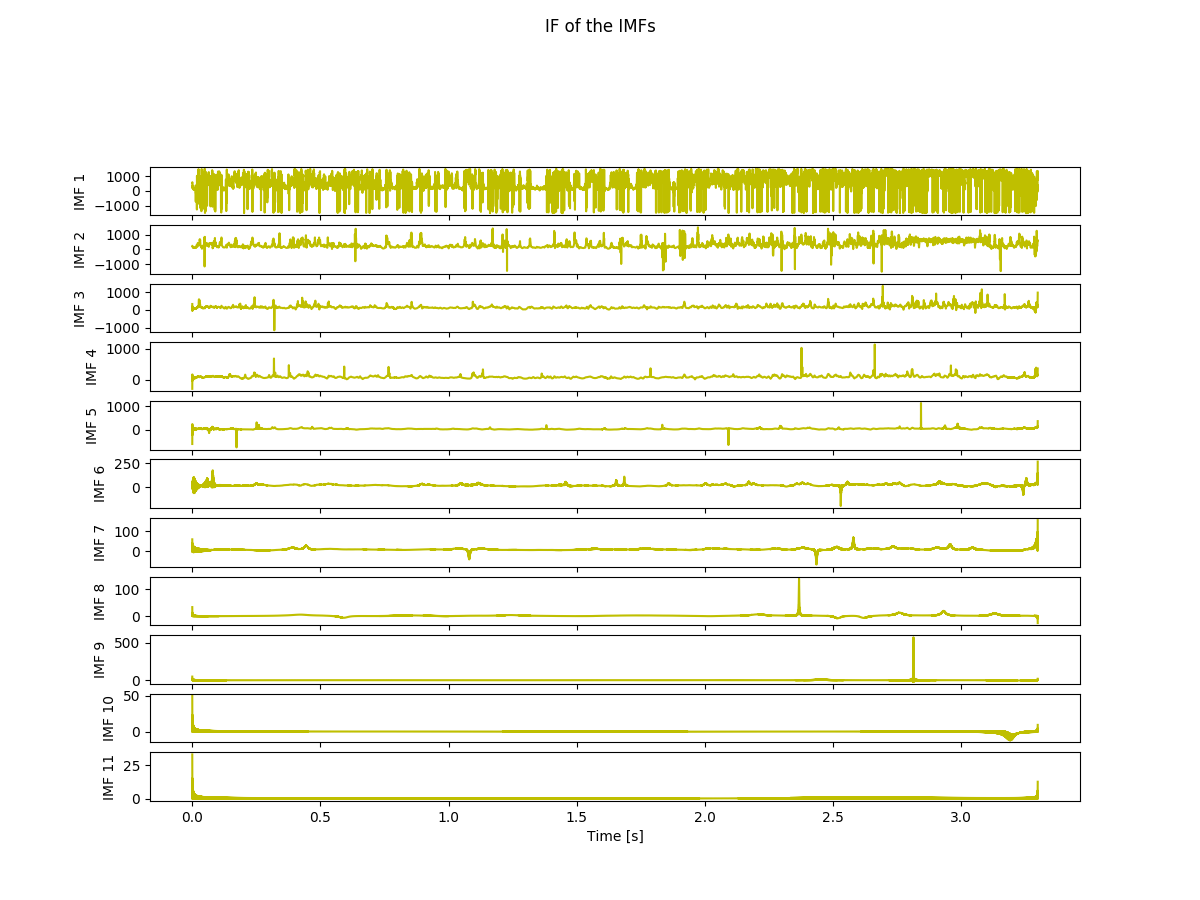

In [10]:
def hilb(s, unwrap=False):
    from scipy.signal import hilbert
    H = hilbert(s)
    amp = np.abs(H)
    phase = np.arctan2(H.imag, H.real)
    if unwrap: phase = np.unwrap(phase)
    return amp, phase

from scipy.signal import hilbert
fs = sr
duration = float(len(audio)) / sr
samples = len(y_filtered)
t = np.arange(samples) / fs
T = 1.0/sr
N = int(duration / T)
plt.figure(figsize=(12,9))
fs = 3000

for n in range(neIMFs):
    #inst_amp, phase = hilb(IMFs[n], unwrap=True)
    #inst_freq = np.diff(phase)
    #instf, timestamps = inst_freq(IMFs[n])
    #plt.plot(timestamps, instf)
    analytic_signal = hilbert(eIMFs[n])
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi) * fs)
    #print(instantaneous_frequency.shape)
    
    plt.subplot(neIMFs+1, 1, n+2)
    plt.plot(t[1:], instantaneous_frequency, 'y')
    plt.ylabel("IMF %i" %(n+1))
    plt.xlabel('Time [s]')
    
plt.suptitle('IF of the IMFs')
plt.savefig('EMD_IF.png', bbox_inches='tight')